#### Kevin O'Kane  @krokane  2385578067

## Text Classification for Sentiment Analysis 

### (a) Intro

In [1]:
#Packages
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import string
import tensorflow as tf

from keras.layers import Embedding, Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

### (b) Data Exploration and Pre-processing 

In [2]:
# Reading in Negative Review Data
# Source: https://www.geeksforgeeks.org/how-to-read-multiple-text-files-from-folder-in-python/
neg_path = '../data/neg'
neg_files = os.listdir(neg_path)

neg_list = []
for i in range(len(neg_files)):
    with open(neg_path+'/'+neg_files[i], 'r') as file: 
        neg_list.append(file.read())

#Remove Punctuation and Numbers
for i in range(len(neg_list)):
    neg_list[i] = neg_list[i].replace('\n','')
    for j in range(len(string.punctuation)):
        neg_list[i] = neg_list[i].replace(string.punctuation[j],'')
    for k in range(len(string.digits)):
        neg_list[i] = neg_list[i].replace(string.digits[k],'')
        
neg_cvs = []
for i in range(len(neg_files)):
    neg_cvs.append(int(neg_files[i].split('_')[0].split('v')[1]))
    
neg = pd.DataFrame()
neg['cv'] = neg_cvs
neg['text'] = neg_list
neg['sentiment'] = [-1] * len(neg_list)
neg['sentiment2'] = [0] * len(neg_list)

In [3]:
# Reading in Positive Review Data
# Source: https://www.geeksforgeeks.org/how-to-read-multiple-text-files-from-folder-in-python/
pos_path = '../data/pos'
pos_files = os.listdir(pos_path)

pos_list = []
for i in range(len(pos_files)):
    with open(pos_path+'/'+pos_files[i], 'r') as file: 
        pos_list.append(file.read())

#Remove Punctuation and Numbers
for i in range(len(pos_list)):
    pos_list[i] = pos_list[i].replace('\n','')
    for j in range(len(string.punctuation)):
        pos_list[i] = pos_list[i].replace(string.punctuation[j],'')
    for k in range(len(string.digits)):
        pos_list[i] = pos_list[i].replace(string.digits[k],'')

pos_cvs = []
for i in range(len(pos_files)):
    pos_cvs.append(int(pos_files[i].split('_')[0].split('v')[1]))
    
pos = pd.DataFrame()
pos['cv'] = pos_cvs
pos['text'] = pos_list
pos['sentiment'] = [1] * len(pos_list)
pos['sentiment2'] = [1] * len(pos_list)

In [4]:
# Create Training and Test Sets
neg_tr = neg[neg['cv'] < 700]
neg_te = neg[neg['cv'] >= 700]

pos_tr = pos[pos['cv'] < 700]
pos_te = pos[pos['cv'] >= 700]

train = pd.concat([neg_tr,pos_tr])
train.index = range(len(train))
test = pd.concat([neg_te,pos_te])
test.index = range(len(test))

In [5]:
#Count Unique Words
all_text = pd.concat([train['text'],test['text']])
all_text.index = range(len(all_text))

unique_words = set()
for i in range(len(all_text)):
    unique_words.update(set(all_text[i].split()))
print(len(unique_words))

46830


In [6]:
# Calculate Review Mean/StDev
review_lens = []

for i in range(len(all_text)):
    review_lens.append(len(all_text[i].split()))

print(round(np.mean(review_lens)))
print(round(np.std(review_lens)))

644
285


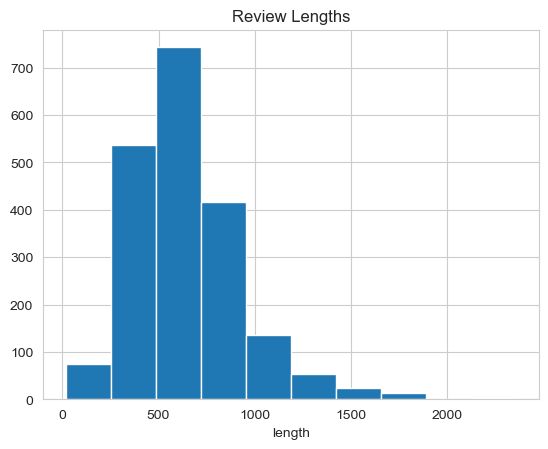

In [7]:
#Review Lengths Histogram
sns.set_style('whitegrid')
plt.hist(review_lens)
plt.title('Review Lengths')
plt.xlabel('length');

In [8]:
#Tokenizing text documents to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)

In [9]:
#Uniform length for encoded sequences on training data, through truncation and padding
#Source: https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
L = int(np.quantile(review_lens,.9))

encoded_train = tokenizer.texts_to_sequences(train['text'])

for i in range(len(encoded_train)):
    if len(encoded_train[i]) > L:
        encoded_train[i] = encoded_train[i][:L]
    else: continue

encoded_train = pad_sequences(encoded_train, maxlen = L)

train['encoded'] = list(encoded_train)

In [10]:
#Repeat for Test Data
encoded_test = tokenizer.texts_to_sequences(test['text'])

for i in range(len(encoded_test)):
    if len(encoded_test[i]) > L:
        encoded_test[i] = encoded_test[i][:L]
    else: continue

encoded_test = pad_sequences(encoded_test, maxlen = L)

test['encoded'] = list(encoded_test)

### (c) Embedding Layer

In [11]:
#Limiting Vocabulary Size
for i in range(len(train)):
    for j in range(len(train['encoded'][i])):
        if train['encoded'][i][j] < 20000: continue
        else: 
            train['encoded'][i][j] = 0

In [12]:
#Repeat for Test Data
for i in range(len(test)):
    for j in range(len(test['encoded'][i])):
        if test['encoded'][i][j] < 20000: continue
        else: 
            test['encoded'][i][j] = 0

### (d) Multi-Layer Perceptron

In [13]:
#Creating Model Structure
#Source: https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
#Source: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#Source: https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

mlp = Sequential()
mlp.add(Embedding(20000,32))
mlp.add(Flatten())
mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(.1))
mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(.1))
mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(.1))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
#Model Fitting
train_x = tf.convert_to_tensor(np.array(train['encoded'].to_list()))
train_y = tf.convert_to_tensor(np.array(train['sentiment'].to_list()))
train_y2 = tf.convert_to_tensor(np.array(train['sentiment2'].to_list()))


test_x = tf.convert_to_tensor(np.array(test['encoded'].to_list()))
test_y = tf.convert_to_tensor(np.array(test['sentiment'].to_list()))
test_y2 = tf.convert_to_tensor(np.array(test['sentiment2'].to_list()))

mlp.fit(x=train_x,y=train_y,batch_size=10,epochs=2, verbose=0);

In [15]:
#Assessing Model Accuracy, Training
mlp_train_loss, mlp_train_accuracy = mlp.evaluate(x=train_x,y=train_y2, verbose=0)

#Assessing Model Accuracy, Test
mlp_test_loss, mlp_test_accuracy = mlp.evaluate(x=test_x,y=test_y2, verbose=0)

print(f'MLP Training Accuracy = {mlp_train_accuracy}')
print(f'MLP Test Accuracy = {mlp_test_accuracy}')

MLP Training Accuracy = 0.5199999809265137
MLP Test Accuracy = 0.5083333253860474


Decreasing the Dropout rate towards 0.1 improved both the test and training accuracy of the model, though both rates were only slightly better than a bernoulli/coin flip. Another adjustment that improved the accuracy of the model was using a sentiment measure of either 0 or 1, instead of -1 or 1. This produced better outcomes with the sigmoid function, including better outcomes over using a tanh activation function with -1 and 1. 

Also, as with all of the models, the accuracy improved when increasing the vocabulary size to 20,000 from 5,000, as well as increasing the length L of the reviews in the model to the 90th percentile, instead of the 70th.

### (e) One-Dimensional Convolutional Neural Network

In [16]:
#Creating Model Structure
cnn = Sequential()
cnn.add(Embedding(20000,32))
cnn.add(Conv1D(32, 3, activation='sigmoid'))
cnn.add(MaxPooling1D(2,2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(.2))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
#Model Fitting
cnn.fit(x=train_x,y=train_y,batch_size=10,epochs=2, verbose=0);

In [18]:
#Assessing Model Accuracy, Training
cnn_train_loss, cnn_train_accuracy = cnn.evaluate(x=train_x,y=train_y2, verbose=0)

#Assessing Model Accuracy, Test
cnn_test_loss, cnn_test_accuracy = cnn.evaluate(x=test_x,y=test_y2, verbose=0)

print(f'CNN Training Accuracy = {round(cnn_train_accuracy,8)}')
print(f'CNN Test Accuracy = {round(cnn_test_accuracy,8)}')

CNN Training Accuracy = 0.5
CNN Test Accuracy = 0.5


Despite adjusting several parameters of the Convulutional Neural Network, including the droupout rate, the batch size, the amount of epochs, and the final activation function, the CNN model didn't perform well, consistently producing a 50%/50% training and test accuracy, the same level of accuracy as a coin flip.


Also, as with all of the models, the accuracy improved when increasing the vocabulary size to 20,000 from 5,000, as well as increasing the length L of the reviews in the model to the 90th percentile, instead of the 70th.

### (f) Long Short-Term Memory Recurrent Neural Network

In [19]:
#Creating Model Structure
lstm = Sequential()
lstm.add(Embedding(20000,32))
lstm.add(LSTM(32, dropout=0.05))
lstm.add(Flatten())
lstm.add(Dense(256,activation='relu'))
lstm.add(Dropout(0.01))
lstm.add(Dense(1,activation='sigmoid'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
#Model Fitting
lstm.fit(x=train_x,y=train_y,batch_size=10,epochs=30, verbose=1)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0000e+00 - loss: 0.2994
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.0111 - loss: -0.3530
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.1063 - loss: -13.5491
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.3711 - loss: -189.8453
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4437 - loss: -723.0648
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4134 - loss: -1512.2856
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4899 - loss: -2685.3530
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4730 - loss: -3977.9333
Epoch 9/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4883 - loss: -5469.7207
Epoch 10/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4767 - loss: -6832.9390
Epoch 11/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4840 - loss: -8703.4766
Epo

In [21]:
#Assessing Model Accuracy, Training
lstm_train_loss, lstm_train_accuracy = lstm.evaluate(x=train_x,y=train_y2, verbose=0)

#Assessing Model Accuracy, Test
lstm_test_loss, lstm_test_accuracy = lstm.evaluate(x=test_x,y=test_y2, verbose=0)

print(f'LSTM Training Accuracy = {round(lstm_train_accuracy,8)}')
print(f'LSTM Test Accuracy = {round(lstm_test_accuracy,8)}')

LSTM Training Accuracy = 0.99857146
LSTM Test Accuracy = 0.69833332


The LSTM Neural Network proudced the best output of the models. Several parameters were adjusted, including dropping the dropout rate from 0.2 to 0.05. An epoch amount of 30 produced the best results for this model, with a training accuracy around 99.5% and a test accuracy around 70%. 

Also, as with all of the models, the accuracy improved when increasing the vocabulary size to 20,000 from 5,000, as well as increasing the length L of the reviews in the model to the 90th percentile, instead of the 70th.